## Atomistic simulation

#### Name: Elina Spinu

In this notebook we will explore concepts from atomistic simulation. To keep the simulations simple, we will be simulating binary collisions rather than collision cascades, which can take a long time to run.

## Setup 

In [2]:
ID = 10095404
vpka = [50.0 + 10.0*ID%14747/14746,0.0,0.0]
print('Your PKA velocity for this notebook is defined as: (%f,%f,%f) ang/ps' % (vpka[0],vpka[1],vpka[2]))

Your PKA velocity for this notebook is defined as: (50.734097,0.000000,0.000000) ang/ps


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import timeit
from scipy.optimize import curve_fit 

We need to define all the functions needed to run a small molecular dynamics simulation. The cell below gathers together all the required functions from the Atomistic Simulation notebook. Execute the cell to define the functions: 

In [4]:
# Calculate Lennard-Jones potential energy of a pair of atoms
def lj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return eps*((r0/R)**12-2.0*(r0/R)**6)+alpha*eps
    else:
        return 0.0
    
# Calculate Lennard-Jones force between a pair of atoms
def flj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return 12*eps/r0*((r0/R)**7-(r0/R)**13)
    else:
        return 0.0
# Return potential energy of a system of atoms
def pe(r):
    pe = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = np.abs(r[j,:]-r[i,:]) # Calculate displacement between atoms
            for s in range(3): # Check if atoms are closer across periodic boundaries in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary  
            R = np.linalg.norm(disp)
            pe = pe + lj(R,eps,r0,rcut,alpha)
    return pe

# Return kinetic energy of a system of atoms
def ke(v,m):
    mconv = 1.036e-4
    ke = 0.0
    for i in range(len(r)):
        ke = ke + m[i]*(v[i,0]*v[i,0] + v[i,1]*v[i,1] + v[i,2]*v[i,2])
    return 0.5*mconv*ke

# Calculate acceleration of a system of atoms
def calcaccln(a,r,m):
    mconv = 1.036e-4
    for i in range(len(r)):
        a[i,:] = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = (r[j,:]-r[i,:]) # Calculate displacement between atoms
            for s in range(3): # Check if atoms are closer across periodic boundaries in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary
                elif disp[s] < -0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] + boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary    
            R = np.linalg.norm(disp)
            a[i,:] = a[i,:] + flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[i]/mconv
            a[j,:] = a[j,:] - flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[j]/mconv
    return R

# Evolve the positions, velocities and accelerations of a system of atoms by one timestep
def vv(r,v,a,m,dt):
    v += 0.5*a*dt
    r += v*dt
    calcaccln(a,r,m)
    v += 0.5*a*dt
    for s in range(3):
        for i in range(len(r)):
            if r[i,s] > boxsize[s]*cell[s,s]:
                r[i,s] = r[i,s] - boxsize[s]*cell[s,s]
    return

# Run a simulation and record key data
def run(r,v,a,m,dt,nsteps):
    R0 = [r[0,:].tolist()]
    R1 = [r[1,:].tolist()]
    V0 = [v[0,:].tolist()]
    V1 = [v[1,:].tolist()]
    A0 = [a[0,:].tolist()]
    A1 = [a[1,:].tolist()]
    pelog = [pe(r)]
    kelog = [ke(v,m)]
    #print('Running simulation of ' + str(nsteps) + ' steps')
    #print('Progress:')
    for t in range(nsteps):
        #if (t+1)%10 == 0:
        #    print(str(t+1) + '.', end='')
        vv(r,v,a,m,dt)
        R0.append(r[0,:].tolist())
        R1.append(r[1,:].tolist())
        V0.append(v[0,:].tolist())
        V1.append(v[1,:].tolist())
        A0.append(a[0,:].tolist())
        A1.append(a[1,:].tolist())
        pelog.append(pe(r))
        kelog.append(ke(v,m))
        #if (t+1)%100 == 0:
        #    print('')
    #print()
    return np.array(R0),np.array(R1),np.array(V0),np.array(V1),np.array(A0),np.array(A1),np.array(pelog),np.array(kelog)

### A note on units 
Times are specified in picosecond (ps), distances in angstrom and energies in electron-volts (eV). 

## Part 1 - The importance of the choice of timestep 
We will explore how the choice of timestep affects the behaviour and reliability of a simulation.

#### <span style="color: red"> Part 1a:</span> Set up a simulation cell for a binary collision 

In [5]:
L = 4
boxsize = np.array([2*L,L,L])
alatt = 2.86
mass = 55.8 
cell = np.array([
        [alatt,0,0],
        [0,alatt,0],
        [0,0,alatt]])
motif = np.array([
        [0.0,0.0,0.0],
        [0.5,0.5,0.5]])
nmotif = len(motif)

r = np.array([[2.0,5.0,5.0],[7.0,5.0,5.0]])
natoms = len(r)
m = np.full(natoms,mass)
v = np.zeros((natoms,3))
a = np.zeros((natoms,3))
eps = 0.7511
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

#### <span style="color: red"> Part 1b:</span> Visualise the simulation cell 

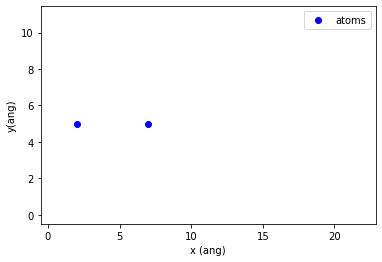

In [6]:

plt.plot(r[:,0],r[:,1],'bo', label = 'atoms')
plt.xlabel('x (ang)')
plt.ylabel('y(ang)')
plt.legend()
plt.xlim(-0.5,cell[0,0]*boxsize[0])
plt.ylim(-0.5,cell[1,1]*boxsize[1]);

#### <span style="color: red"> Part 1c:</span> Run the simulation 

In [7]:
dt = 0.0001
vpka = [50.734097,0.000000,0.000000]
v[0,:] = vpka
R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)

In [8]:
print(kelog[:]-kelog[0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.00472067e-05
 -6.00472067e-05 -6.00472067e-05]


#### <span style="color: red"> Part 1d:</span> Plotting the change in total energy as a function of time 

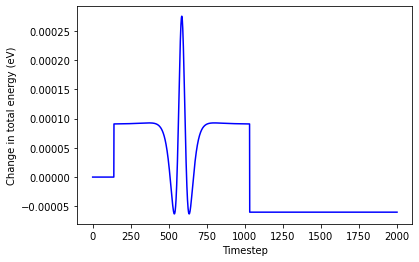

In [9]:
plt.plot(kelog[:]+pelog[:]-kelog[0]-pelog[0],'b-')
plt.xlabel('Timestep')
plt.ylabel('Change in total energy (eV)');

What gives rise to the first step feature is probably atoms colliding and then the oscillating feature is caused by them stabilising after collision, the second step feature are atoms returning to rest.

#### <span style="color: red"> Part 1e:</span> Exploring the effect of the timestep on energy conservation
We will run simulations of collisions just like the one above for a following range of values of the timestep `dt` $[0.00001, 0.0001, 0.001, 0.01]$. To keep overaal duration the same the corresponding set of numbers of steps will be $[20000,2000,200,20]$.

For each simulation, we will record the change in total energy between the first and last step in a list. This is a measure of the lack of energy conservation in the simulation.

In [10]:
dt = [0.00001,0.0001,0.001,0.01]
steps = [20000,2000,200,20]
techange = []
for i in range(4):
    r = np.array([[2.0,5.,5.0],[7.0,5.0,5.0]])  
    natoms = len(r)
    mass = 55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    vpka = [50.734097,0.000000,0.000000]
    v[0,:] = vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt[i],steps[i])
    techange.append(kelog[steps[i]]-kelog[0])
print(techange)



[-9.400819922511516e-06, -6.004720671448638e-05, 0.00013755494096034937, 18.166842723647477]


#### <span style="color: red"> Part 1f:</span> Plotting a graph of energy change against the value of the timestep `dt` 

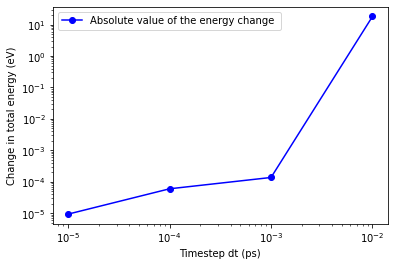

In [11]:
abstechange=[]
for number in techange:
    abstechange.append(abs(number))


plt.loglog(dt,abstechange,'bo-', label ='Absolute value of the energy change ')
plt.xlabel('Timestep dt (ps)')
plt.ylabel('Change in total energy (eV)')
plt.legend();

The resulting behaviour is that the energy loss grows as the timestep grows, reaching intolerably large value at dt = 0.01. This can be explained - the bigger we make dt - the faster and more efficient our simulation will be, but also it will be less accurate, as it will less accuratly integrate the differentiational equation. 

#### <span style="color: red"> Part 1g:</span> Plotting a graph of the distance moved by the projectile atom (atom 0) in the first timestep of the simulation 

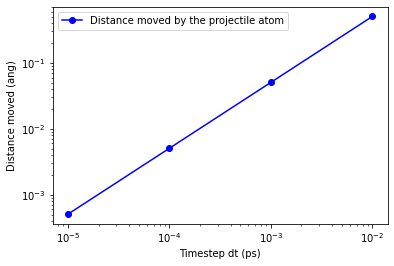

In [12]:
distance = []
for number in dt:
    distance.append(number*50.734097)
plt.loglog(dt,distance,'bo-', label = "Distance moved by the projectile atom")
plt.xlabel("Timestep dt (ps)")
plt.ylabel("Distance moved (ang)")
plt.legend();

The bigger the timestep - the bigger is the generalisation, so the biggest timestep divides the same process into the least parts and for a value of displacement that is finite (atom coming to rest after some time) - big timestep will give larger values in the first step of the simulation, while small dt will give smaller values. 

## Part 2 - Energy transfer 
We will now investigate the amount of energy tranferred from the projectile atom (atom 0) to the target atom (atom 1) during the collision as a function of the *impact parameter* of the collision. The impact parameter is defined as the perpendicular distance of the target atom from a straight line projection of the initial trajectory of the projectile atom.

As well as simulating the collision process we will consider it in an analytical treatment and see how well a simple theory matches our results.

#### <span style="color: red"> Part 2a:</span> Defining a function to return the value of the kinetic energy for a single atom 

In [13]:
def keatom(v,m):
    mconv = 1.036e-4
    keatom = m*(np.sum(v**2))
    return 0.5*mconv*keatom


#### <span style="color: red"> Part 2b:</span> Running simulations with a variety of impact parameters 

In [14]:
b = [0.0,0.1,0.2,0.5,1.0,2.0]
dt = 0.0001

fraction = []
for i in b:
    r = np.array([[2.0,5.0+i,5.0],[7.0,5.0,5.0]])
    natoms = len(r)
    vpka = [50.734097,0.000000,0.000000]
    
    mass = 55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    v[0,:]=vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)
    
    finalv=np.linalg.norm(V1[-1,:])
    Einitial = keatom(vpka[0],mass)
    Etransf = keatom(finalv,mass)
    fraction.append(Etransf/Einitial)
    
print(fraction)

[0.9999919289533514, 0.9975567252974628, 0.9900798989366272, 0.9384031494649728, 0.7611550016622123, 0.19500127063768155]


#### <span style="color: red"> Part 2c:</span> Plotting the fraction of kinetic energy trasferred as a function of impact parameter 

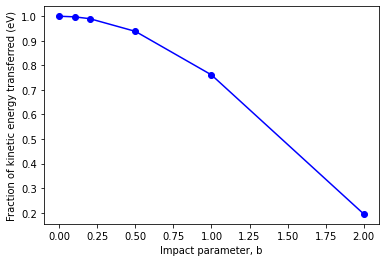

In [15]:
plt.plot(b,fraction, 'bo-')
plt.xlabel('Impact parameter, b')
plt.ylabel('Fraction of kinetic energy transferred (eV)');

### A theoretical treatment of the collision
The above plot should show a well behaved trend. Can we explain the form of this trend using some simple theory?

First, let's make some simplifications in our analysis of the collision process. Let's assume that the interaction between the atoms is only significant when they are within a certain range that we denote $r^{\ast}$. This means that the forces between the atoms will only act to transfer energy when the atoms are within a distance of $r^{\ast}$ or less. We will also assume that we can approximate the energy transfer in the true collision process by assuming that it is the same as would have occurred if the particles followed their unperturbed paths (i.e. the target atom remains stationary and the projectile moves in a straight line. 


The change in momentum of a particle (also called an *impulse*) $\Delta p$ of a particle experiencing a force $F$ for a time $t$ is given by $\Delta p = F t$ (you can see this if you remember Newton's second law, that a force is a rate of change of velocity multipled by mass). Now, since the target particle is initially at rest, the kinetic energy transfer is simply the value of its final kinetic energy. If it receives momentum $\Delta p$ then this kinetic energy change is:

$$
\Delta E_{\mathrm{kin}} = \frac{\Delta p^2}{2m}.
$$

Now, from the figure, we can see that the length of the projectile trajectory within range $r^{\ast}$ is given by $x = 2\,\sqrt{{r^{\ast}}^2-b^2}$ which, for a projectile speed $v$ implies a time over which a significant force acts of

$$
t = x/v = 2(\sqrt{{r^{\ast}}^2-b^2})/v.
$$

Inserting this into our expression for the kinetic energy transfer and gathering together the various factors into a constant $\beta$ gives

$$
\Delta E_{\mathrm{kin}} = \frac{\Delta p^2}{2m} = \frac{(F\,t)^2}{2m} = \frac{F^2}{2m v^2}4({r^{\ast}}^2-b^2) = \beta \,({r^{\ast}}^2-b^2).
$$

Now, we know from basic physics that in a perfectly elastic head-on collision between two particles of equal mass, the kinetic energy transfer is complete. This is to say that the value of $\Delta E_{\mathrm{kin}}$ must be 1.0 when $b=0$, which means we must have $\beta { r^{\ast}}^2=1$,  and so our final theoretical expression reads:

$$
\Delta E_{\mathrm{kin}} = 1 -\beta b^2.
$$

What we can do is fit the value of $\beta$ to our simulation data to verify the *form* of the model that we have derived.

#### <span style="color: red"> Part 2d:</span> Defining a python function for the kinetic energy tranfer as a function of impact parameter and fitting the value of the $\beta$ parameter 

In [16]:
def demodel(b,beta):
    Ekit = 1 - beta*np.power(b,2)
    return Ekit
pars,cov = curve_fit(demodel,b,fraction)
beta = pars[0]
bf=np.linspace(0,2,50)
fractionfit= demodel(bf,beta)
print(beta)

0.20362281064057502


#### <span style="color: red"> Part 2e:</span> Plotting the fitted model against the simulation data 

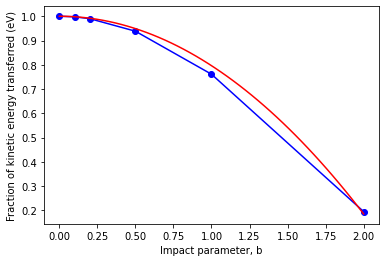

In [19]:
plt.plot(b,fraction, 'bo-', label='og')
plt.plot(bf,fractionfit,'-r')
plt.xlabel('Impact parameter, b')
plt.ylabel('Fraction of kinetic energy transferred (eV)');

The fit is very good for the values of b lower then 0.5, but as the impact parameter grows - the fit overstimates the fraction of kinetic energy transferred. Returning to being accurate for the value $\beta$=2.0.

#### <span style="color: red"> $\beta$ 2f:</span> Calculating the value of $r^{\ast}$ 

Beta*(r*)^2=1, then

In [20]:
rstar = np.sqrt(1/beta)
print(rstar)

2.216086898006772


In the Lennard-Jones potential curve with the parameterisation for Fe the energy is at a minimum at a position defined by the value of r0, which is the separation at which the force between an isolated pair of atoms goes to 0. In our case the forces will only act to transfer energy if the distance is r* or less. 

## Part 3 

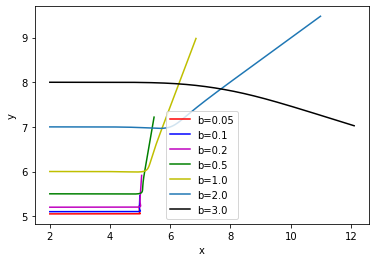

In [21]:
b=[0.05,0.1,0.2,0.5,1.0,2.0,3.0]
dt = 0.0001
for i in b:
    r = np.array([[2.0,5.0+i,5.0],[7.0,5.0,5.0]])
    natoms = len(r)
    vpka = [50.734097,0.000000,0.000000]
    mass = 55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    v[0,:]=vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)
    if i == 0.05:
        plt.plot(R0[:,0],R0[:,1], 'r-', label='b=0.05')
        
    elif i == 0.1:
        plt.plot(R0[:,0],R0[:,1], 'b-',label='b=0.1')
       
    elif i == 0.2:
        plt.plot(R0[:,0],R0[:,1], 'm-',label='b=0.2')
        
    elif i == 0.5:
        plt.plot(R0[:,0],R0[:,1], 'g-',label='b=0.5')
        
    elif i == 1.0:
        plt.plot(R0[:,0],R0[:,1], 'y-',label='b=1.0')

    elif i == 2.0:
        plt.plot(R0[:,0],R0[:,1], label='b=2.0' )
       
    elif i == 3.0:
        plt.plot(R0[:,0],R0[:,1], 'k-',label='b=3.0')
        
    
    
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in arccos


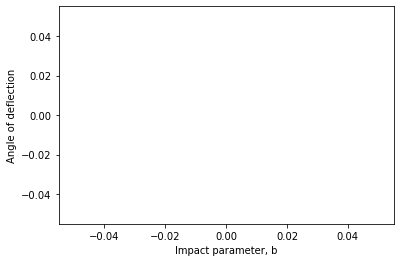

In [22]:
angles=[]
b=[0.05,0.1,0.2,0.5,1.0,2.0,3.0]
dt = 0.0001
for i in b:
    r = np.array([[2.0,5.0+i,5.0],[7.0,5.0,5.0]])
    natoms = len(r)
    vpka = [50.734097,0.000000,0.000000]
    mass = 55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    v[0,:]=vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)
    v1=V0[0,:]
    v2 =V0[-1,:]

    uvec1 = v1/(np.linalg.norm(v1))
    uvec2 = v2/(np.linalg.norm(v2))
    dotprod=np.dot(v1,v2)
    angles.append(np.arccos(dotprod))
    
plt.plot(b,angles,'bo-')
plt.xlabel('Impact parameter, b')
plt.ylabel('Angle of deflection');

For b=3 it seems that the atoms fail to interact, the value of b makes the distance between the atoms be greater then r*, the trajectrory has a negative angle.